In [1]:
from skyfield.api import load, EarthSatellite, Topos
from geopy.geocoders import Nominatim
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
# Fetch latest ISS TLE from CelesTrak
def fetch_iss_tle():
    url = "https://celestrak.org/NORAD/elements/stations.txt"
    response = requests.get(url)
    lines = response.text.strip().split('\n')
    for i in range(len(lines)):
        if "ISS" in lines[i]:
            return lines[i], lines[i+1], lines[i+2]
    raise Exception("ISS TLE not found.")

# Load satellite using Skyfield
ts = load.timescale()
name, line1, line2 = fetch_iss_tle()
satellite = EarthSatellite(line1, line2, name, ts)


In [3]:
def get_coords(city_name):
    geolocator = Nominatim(user_agent="iss_tracker")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError("City not found.")


In [4]:
from datetime import datetime, timedelta, timezone
from skyfield.api import load, EarthSatellite, Topos, utc

def next_pass(city_name):
    ts = load.timescale()
    lat, lon = get_coords(city_name)
    location = Topos(latitude_degrees=lat, longitude_degrees=lon)

    # Use timezone-aware datetime in UTC
    now = datetime.now(tz=utc)
    tomorrow = now + timedelta(days=1)
    
    t0 = ts.from_datetime(now)
    t1 = ts.from_datetime(tomorrow)

    times, events = satellite.find_events(location, t0, t1, altitude_degrees=30.0)

    for t, e in zip(times, events):
        name = ('Rise 🌅', 'Culminate 🌕', 'Set 🌇')[e]
        print(f"{name}: {t.utc_datetime():%Y-%m-%d %H:%M:%S UTC}")


In [5]:
next_pass("Delhi")


Rise 🌅: 2025-07-14 21:02:25 UTC
Culminate 🌕: 2025-07-14 21:03:54 UTC
Set 🌇: 2025-07-14 21:05:23 UTC
Rise 🌅: 2025-07-15 12:03:08 UTC
Culminate 🌕: 2025-07-15 12:04:38 UTC
Set 🌇: 2025-07-15 12:06:08 UTC


In [6]:
from datetime import datetime, timedelta, timezone

def plot_ground_track(duration_minutes=90):
    ts = load.timescale()
    start_time = datetime.now(timezone.utc)
    
    datetimes = [start_time + timedelta(minutes=i) for i in range(duration_minutes)]
    times = ts.from_datetimes(datetimes)

    lats, lons = [], []
    for t in times:
        geo = satellite.at(t).subpoint()
        lats.append(geo.latitude.degrees)
        lons.append(geo.longitude.degrees)

    plt.figure(figsize=(12, 6))
    plt.title("ISS Ground Track (Next 90 Minutes)")
    plt.plot(lons, lats, label='ISS Path')
    plt.scatter(lons[0], lats[0], color='red', label='Current Position')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.show()


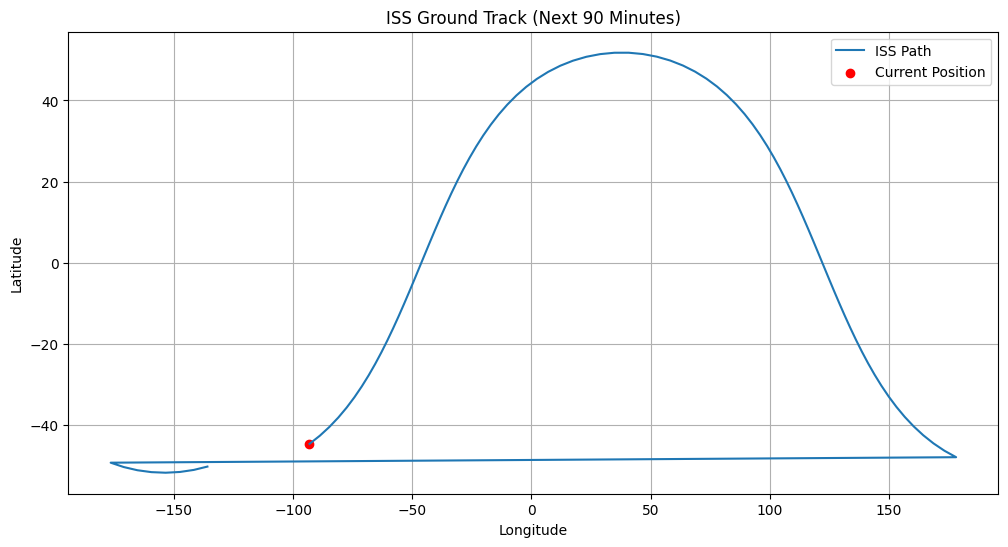

In [7]:
plot_ground_track()


In [8]:
import csv
from datetime import datetime, timedelta, timezone

def batch_iss_passes(csv_file):
    t0 = ts.from_datetime(datetime.now(timezone.utc))
    t1 = ts.from_datetime(datetime.now(timezone.utc) + timedelta(days=1))

    print(f"{'City':<15} {'Rise Time':<25} {'Culmination':<25} {'Set Time':<25}")

    with open(csv_file, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            city = row['City']
            lat = float(row['Latitude'])
            lon = float(row['Longitude'])
            location = Topos(latitude_degrees=lat, longitude_degrees=lon)
            
            try:
                times, events = satellite.find_events(location, t0, t1, altitude_degrees=30.0)
                
                rise_time = times[0].utc_datetime().strftime('%Y-%m-%d %H:%M:%S UTC')
                culminate_time = times[1].utc_datetime().strftime('%Y-%m-%d %H:%M:%S UTC')
                set_time = times[2].utc_datetime().strftime('%Y-%m-%d %H:%M:%S UTC')
                
                print(f"{city:<15} {rise_time:<25} {culminate_time:<25} {set_time:<25}")
            
            except Exception as e:
                print(f"{city:<15} Error calculating pass times.")


In [9]:
batch_iss_passes("locations.csv")


City            Rise Time                 Culmination               Set Time                 
Delhi           2025-07-14 21:02:25 UTC   2025-07-14 21:03:54 UTC   2025-07-14 21:05:23 UTC  
Mumbai          2025-07-15 12:00:47 UTC   2025-07-15 12:02:01 UTC   2025-07-15 12:03:15 UTC  
Bengaluru       Error calculating pass times.
Kolkata         2025-07-14 21:06:15 UTC   2025-07-14 21:06:51 UTC   2025-07-14 21:07:28 UTC  
Hyderabad       2025-07-14 21:05:54 UTC   2025-07-14 21:06:23 UTC   2025-07-14 21:06:52 UTC  


In [10]:
cities = {
    "Delhi": (28.6139, 77.2090),
    "Mumbai": (19.0760, 72.8777),
    "Bengaluru": (12.9716, 77.5946),
    "Kolkata": (22.5726, 88.3639),
    "Hyderabad": (17.3850, 78.4867)
}

city_dropdown = widgets.Dropdown(
    options=cities.keys(),
    description='City:'
)

duration_slider = widgets.IntSlider(
    value=90,
    min=30,
    max=180,
    step=10,
    description='Track (min):'
)

run_button = widgets.Button(description="Track ISS")
output = widgets.Output()


In [11]:
def run_iss_tracking(city, duration=90):
    print(f"Running ISS Tracker for: {city}, Duration: {duration} minutes")
    
    lat, lon = cities[city]

    # Next pass prediction
    t0 = ts.from_datetime(datetime.now(timezone.utc))
    t1 = ts.from_datetime(datetime.now(timezone.utc) + timedelta(days=1))
    location = Topos(latitude_degrees=lat, longitude_degrees=lon)
    times, events = satellite.find_events(location, t0, t1, altitude_degrees=30.0)

    print(f"\n🛰️ Next pass for {city} (Lat: {lat}, Lon: {lon}):")
    for t, e in zip(times, events):
        name = ('Rise 🌅', 'Culminate 🌕', 'Set 🌇')[e]
        print(f"{name}: {t.utc_datetime():%Y-%m-%d %H:%M:%S UTC}")

    # Plot ground track
    plot_ground_track(duration)


Running ISS Tracker for: Mumbai, Duration: 90 minutes

🛰️ Next pass for Mumbai (Lat: 19.076, Lon: 72.8777):
Rise 🌅: 2025-07-15 12:00:47 UTC
Culminate 🌕: 2025-07-15 12:02:01 UTC
Set 🌇: 2025-07-15 12:03:15 UTC


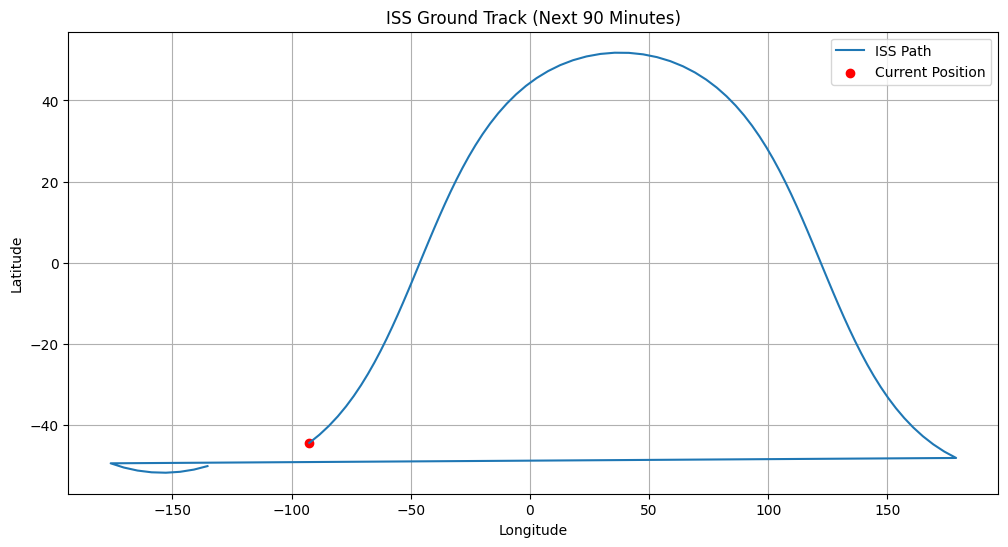

In [12]:
run_iss_tracking("Mumbai", 90)